In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant
from scipy.linalg import toeplitz, hankel
from IPython.display import clear_output
from scipy.linalg import expm
import pickle


#### --------- Definition of variables ------------------------

N_size=50001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------
def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f


display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))


def Get_Bands_Matrix(N_size,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        M_minous=[((m_cos[np.abs(int(i))]-m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        M_plus = [((m_cos[np.abs(int(i))]+m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        Mminousband=np.array(M_minous)
        Mplusband=np.array(M_plus)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,n=i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,n=i) else 0.5 for i in x]
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)

        M_minous=[((m_cos[np.abs(int(i))]-m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        M_plus = [((m_cos[np.abs(int(i))]+m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        Mminousband=np.array(M_minous)
        Mplusband=np.array(M_plus)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fft(ifftshift(Mplusband))
    Fourier_minous=fft(ifftshift(Mminousband))
    return Fourier_plus/N_size,Fourier_minous/N_size

def Toeplitz_matrix(Fourier_plus,L):
    First_column = Fourier_plus[:L]
    First_row = np.roll(Fourier_plus,-1)[::-1][:L]
    return toeplitz(First_column,First_row)
def Hankel_matrix(Fourier_minous,L):
    to_use=Fourier_minous[:2*L-1]
    First_column=to_use[:L]
    Last_row=np.roll(to_use,-L+1)[:L]
    return hankel(First_column,Last_row)

def Covariance_matrix(L,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,N_size=N_size,Ground=False):
    if Ground:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=True)
    else:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=False)
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))

def Covariance_matrix_from_sub_sample(Fourier_plus,Fourier_minous,L):
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))


def print_progress(total,step,num=50):
    message="["+"="*int(num*((step/total)))+" "*int(num*(1-(step/total)))+"]"
    message+="  "+str(round(step/total*100,3))+ " "+ "%"
    print(message,end="\r")

In [10]:
N_size=50001
L=11
beta=0.40824
# -----------------------------
num_data=2000
Data=np.zeros((num_data,N_size,2))
for i in range(num_data):
    print_progress(num_data,i+1)
    a,b=Get_Bands_Matrix(N_size,Ground=False)
    Data[i,:,0]=a.real
    Data[i,:,1]=b.real

In [11]:
data_fourier= open('data.pkl', 'wb') 
pickle.dump(Data, data_fourier)

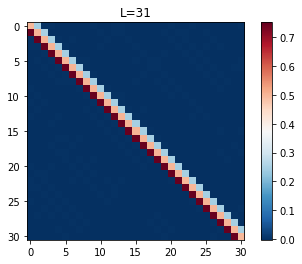

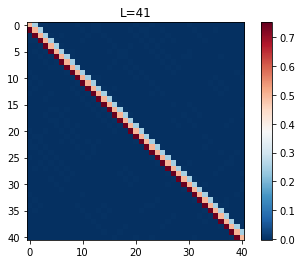

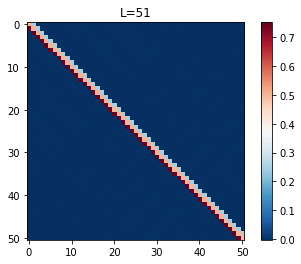

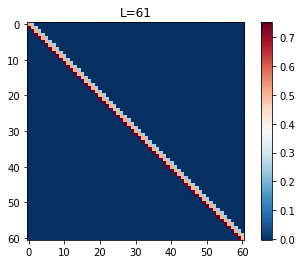

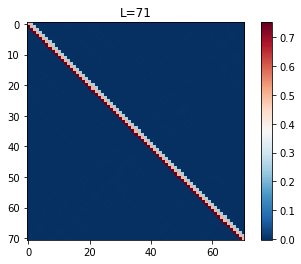

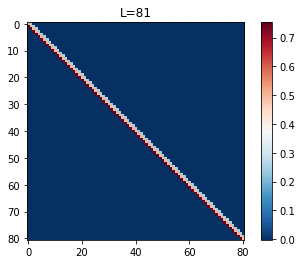

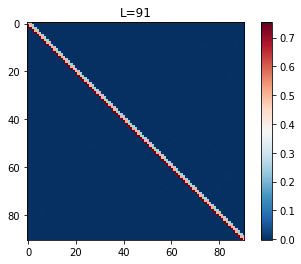

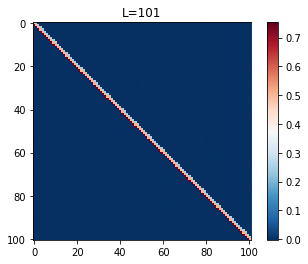

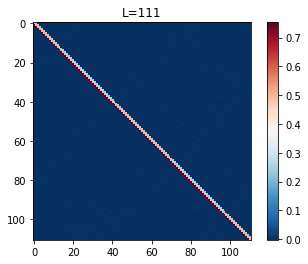

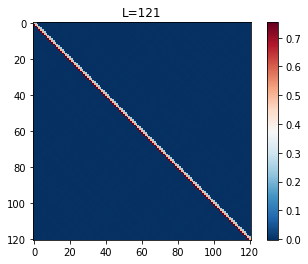

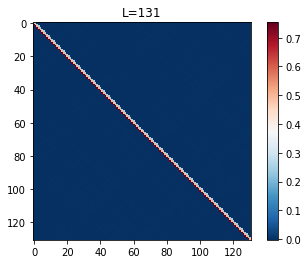

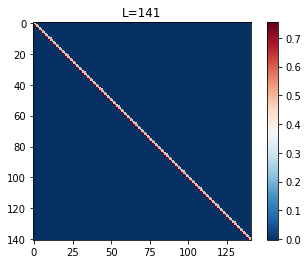

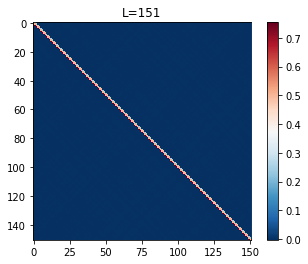

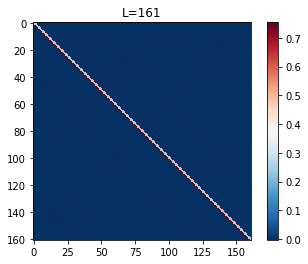

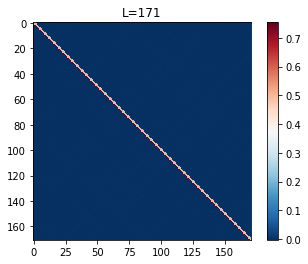

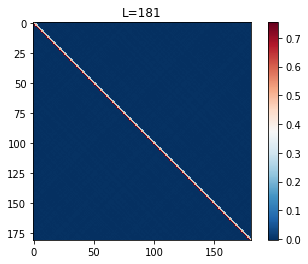

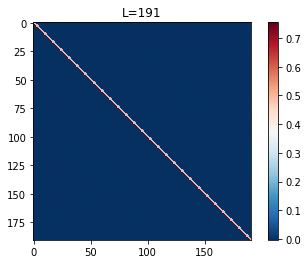

In [4]:
for L in np.arange(31,200,10):
    M_final=np.zeros((L,L))
    for i in range(num_data):
        New_cov_matrix=Covariance_matrix_from_sub_sample(Data[i,:,0],Data[i,:,1],L)
        A,S,B=np.linalg.svd(New_cov_matrix)
        O_1,S,O_2=np.linalg.svd(New_cov_matrix)
        S=-S+0.5
        x=np.log((1-S)/(S))
        M=(-(O_1@np.diag(x)/beta@O_2).real)
        M_final+=M
    plt.title("L={}".format(L))
    plot=plt.imshow(M_final/num_data,cmap="RdBu_r")
    plt.colorbar()
    plt.show()

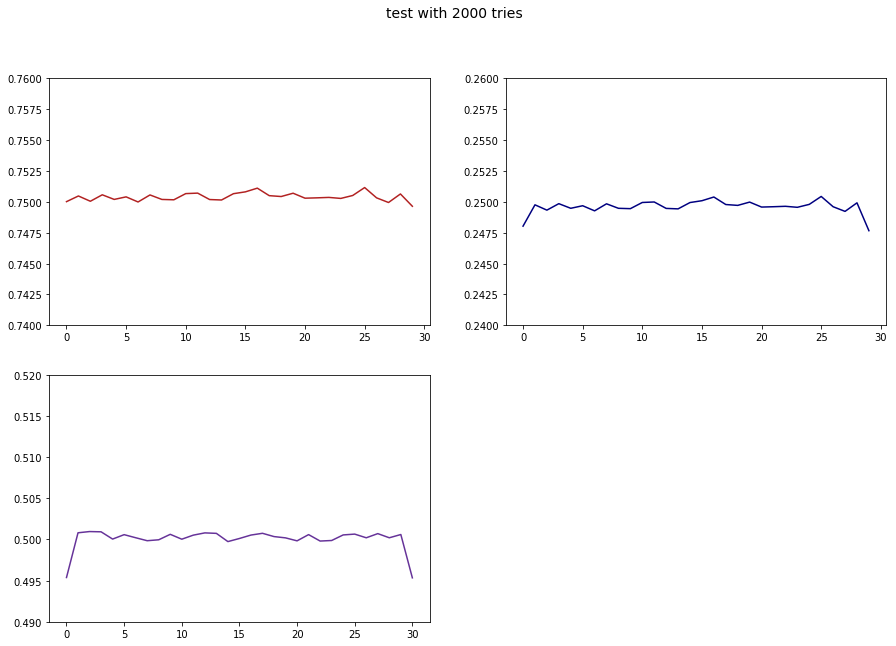

In [12]:
L=31
M_final=np.zeros((L,L))
for i in range(num_data):
    New_cov_matrix=Covariance_matrix_from_sub_sample(Data[i,:,0],Data[i,:,1],L)
    A,S,B=np.linalg.svd(New_cov_matrix)
    O_1,S,O_2=np.linalg.svd(New_cov_matrix)
    S=-S+0.5
    x=np.log((1-S)/(S))
    M=(-(O_1@np.diag(x)/beta@O_2).real)
    M_final+=M
    if (i+1)%10==0:
        clear_output(wait=True)
        lower_band=np.array([[M_final[i,j] for i in range(1,L) if i-j == 1] for j in range(L-1)]).reshape(L-1)/(i+1)
        upper_band=np.array([[M_final[i,j] for i in range(L) if i-j == -1] for j in range(1,L)]).reshape(L-1)/(i+1)
        diag=M_final.diagonal()/(i+1)
        fig=plt.figure(figsize=(15,10))
        fig.suptitle("test with {} tries".format(i+1), fontsize=14)
        plt.subplot(2,2,1)
        plt.plot(lower_band,color="firebrick")
        plt.ylim(0.74,0.76)
        plt.subplot(2,2,2)
        plt.plot(upper_band,color="navy")
        plt.ylim(0.24,0.26)
        plt.subplot(2,2,3)
        plt.ylim(0.49,0.52)
        plt.plot(diag,color="rebeccapurple")
        plt.show()
        
        
    

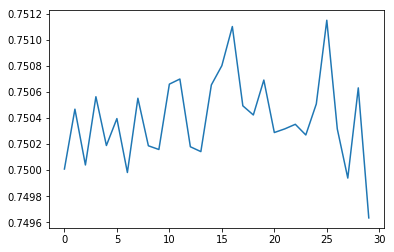

In [14]:
plt.plot(lower_band)